# Node2Vec Analysis

This file is concerned with analysing the graph that is created in `network_analysis.ipynb` using node2vec. 

## Node2Vec Preparation


In [1]:
import csv

In [2]:
def format_edgelist(edgelist_filename: str, output_filename: str):
    with open(edgelist_filename, 'r', encoding='utf-8') as readfile:
        csv_reader = csv.reader(readfile)
        next(csv_reader)

        with open(output_filename, 'w', encoding='utf-8') as writefile:
            for row in csv_reader:
                source = row[0]
                target = row[1]
                weight = float(row[2])
                output_string = '\t'.join(map(str, [source, target, weight]))
                writefile.write(f"{output_string}\n")


def format_edgelist_without_weight(edgelist_filename: str, output_filename: str):
    with open(edgelist_filename, 'r', encoding='utf-8') as readfile:
        csv_reader = csv.reader(readfile)
        next(csv_reader)

        with open(output_filename, 'w', encoding='utf-8') as writefile:
            for row in csv_reader:
                source = row[0]
                target = row[1]
                output_string = '\t'.join(map(str, [source, target]))
                writefile.write(f"{output_string}\n")


In [3]:
edgelist_filename = "../data/too_big/all_games_filtered.csv"
output_filename = "./test.edgelist"
format_edgelist_without_weight(edgelist_filename, output_filename)

## Embedding Generation

This implementation of node2vec can be found [here](https://pecanpy.readthedocs.io/en/latest/pecanpy.html#module-pecanpy.pecanpy). The method of generating the embeddings is based on [this](https://github.com/krishnanlab/PecanPy/blob/master/src/pecanpy/cli.py#L334).

In [4]:
#%pip install pecanpy ipywidgets
from pecanpy import pecanpy as node2vec
from gensim.models import Word2Vec, KeyedVectors

In [5]:
def generate_embeddings(input_edgelist: str, output_filename: str, p=1, q=1, num_dimensions=16, num_walks=10, walk_length=80):
    window_size = 10
    num_workers = 0
    num_epochs = 1
    random_state = 0

    g = node2vec.SparseOTF(p=p, q=q, workers=0, verbose=True)
    g.read_edg(input_edgelist, weighted=True, directed=True)
    walks = g.simulate_walks(num_walks, walk_length)
    model = Word2Vec(
        walks,
        vector_size=num_dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=num_workers,
        epochs=num_epochs,
        seed=random_state,
    )
    
    model.wv.save_word2vec_format(output_filename)

In [23]:
# Generate the embeddings using an edgelist.
input_edgelist = "../data/too_big/all_games_filtered.edgelist"
output_filename = "./test.emb"
generate_embeddings(input_edgelist, output_filename,
                    p=0.25, q=0.1, num_dimensions=64)


  0%|          | 0/304330 [00:00<?, ?it/s]

## Node2Vec Analysis

In this notebook, we are using the graph embeddings generated from `node2vec` to discover deeper insight from the graph created by `data/games/network/all_games.csv`.

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
homophily_embeddings = "../data/games/network/homophily.emb"
structural_equivalence_embeddings = "../data/games/network/structural_equivalence.emb"

homophily_df = pd.read_csv(homophily_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None).add_prefix("dim_")
homophily_df.rename(columns={0: 'id'}, inplace=True)

structural_equivalence_df = pd.read_csv(structural_equivalence_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None).add_prefix("dim_")
structural_equivalence_df.rename(columns={0: 'id'}, inplace=True)


### Node Similarity

In [17]:
import pandas as pd
from gensim.models import KeyedVectors

def get_vectors_from_embeddings(input_embeddings_filename: str):
    return KeyedVectors.load_word2vec_format(input_embeddings_filename, binary=False)

def format_games_metadata_dataframe(df: pd.DataFrame):
    # Remove row if game do not have a created date.
    # df.drop(df[df['created_date'] == 'None'].index, inplace=True)

    # Remove rows with N/As in them.
    # df = df.dropna()

    # Format the release_date and created_date to be an actual date type.
    # df['release_date'] = pd.to_datetime(df['release_date'])
    # df['created_date'] = pd.to_datetime(
    #     df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    # df['release_date'] = pd.to_datetime(
    #     df['release_date'].dt.strftime('%Y-%m-%d'))
    # df['created_date'] = pd.to_datetime(
    #     df['created_date'].dt.strftime('%Y-%m-%d'))

    # # Remove rows with a created date or release date before cutoff.
    # df = df[(df['created_date'] < '2023-01-01') &
    #         (df['release_date'] < '2023-01-01')]

    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[[
        'num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)

    # Rename the game_id column to just id.
    df.rename(columns={'game_id': 'id'}, inplace=True)

    return df

def find_most_similar_games(game_id: str, node_vectors: KeyedVectors, metadata_df: pd.DataFrame) -> pd.DataFrame:
    most_similar = node_vectors.most_similar(game_id, topn=30)
    most_similar_df = pd.DataFrame(most_similar)
    most_similar_df.loc[-1] = [game_id, 0]
    most_similar_df.rename(columns={0: 'id', 1: 'similarity_value'}, inplace=True)
    return metadata_df.merge(most_similar_df, on='id', how='inner').sort_values(by='similarity_value', ascending=False)


In [24]:
node_vectors = get_vectors_from_embeddings("./test.emb")
games_metadata_df = pd.read_csv("../data/games/metadata/all_games.csv")
games_metadata_df = format_games_metadata_dataframe(games_metadata_df)

In [27]:
game_id = "o1y9j9v6"
most_similar_df = find_most_similar_games(game_id, node_vectors, games_metadata_df)
most_similar_df

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,similarity_value
21,kdknr2dm,HackyZack,k62d48ex,2017-03-28,2017-04-10T04:57:17Z,11,6,21,2,0,0.481032
10,4d7xln17,Legacy of Kain: Soul Reaver 2,81e7mde7,2001-10-31,2015-01-11T04:58:00Z,6,5,23,8,0,0.461541
11,m1zjg336,Ozzy and Drix (GBA),None,2003-12-17,2020-03-01T21:41:38Z,1,0,2,2,0,0.456378
25,j1lloe41,Emote Challenge 64,k62n976x,2018-08-19,2018-08-27T18:53:35Z,2,13,3,3,0,0.451694
9,pd0w7231,Monkey King,None,2001-01-01,2018-07-20T08:36:41Z,1,0,5,3,0,0.434464
28,pdvzevr6,The Mystery of Herobrine,ne4vw1em,2020-04-07,2020-09-03T16:08:47Z,4,6,29,3,0,0.434316
4,pd0w8pw1,PowerFest '94,None,1994-11-20,2021-01-27T21:19:30Z,4,0,6,1,0,0.428156
20,j1n30ydp,Deponia Doomsday,nzmg8gz0,2016-03-01,2016-02-27T10:19:57Z,1,0,14,5,0,0.420010
12,kdkr9q6m,Yu-Gi-Oh! GX Tag Force,None,2006-09-14,2015-07-17T21:28:58Z,2,0,37,10,0,0.419324
17,4d783367,Earth Defense Force 4.1 The Shadow of New Despair,None,2015-04-02,2016-08-03T05:15:12Z,4,147,169,12,4,0.417527


In [93]:
print(f"Distance: {node_vectors.distance('o1y9okr6', 'j1llqye1')}, Similarity: {node_vectors.similarity('o1y9okr6', 'j1llqye1')}")


Distance: 0.1742321252822876, Similarity: 0.8257678747177124


### PCA and Clustering

In [119]:
df = structural_equivalence_df.copy()

### Principal Component Analysis

(30433, 2)


Text(0, 0.5, 'pc2')

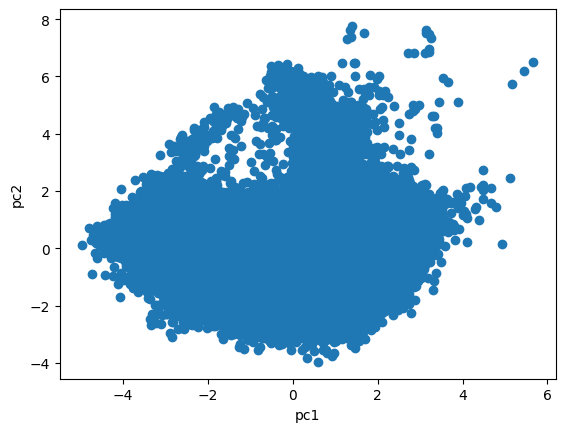

In [120]:
#%pip install scikit-learn scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

number_of_components = 2

scaled_df = StandardScaler().fit_transform(df)
pca = PCA(number_of_components)
transformed_df = pca.fit_transform(scaled_df)

print(transformed_df.shape)

plt.scatter(transformed_df[:,0],transformed_df[:,1])
plt.xlabel('pc1')
plt.ylabel('pc2')

### K-Means Clustering

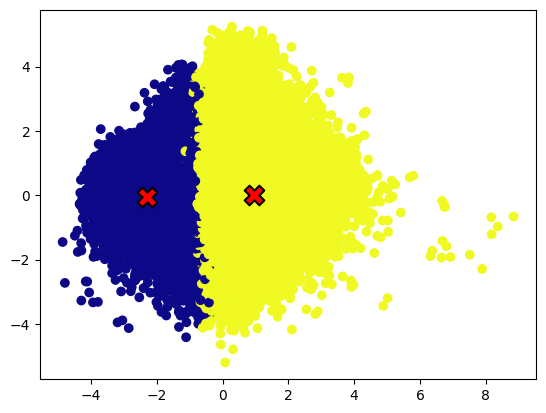

In [87]:
from sklearn.cluster import KMeans

number_of_clusters = 2

kmeans = KMeans(n_clusters=number_of_clusters, random_state=0, n_init='auto')
kmeans.fit(scaled_df)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(transformed_df[:, 0],transformed_df[:, 1],c=labels,cmap='plasma')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)
plt.show()

### Hyper Parameter Tuning K-Means Clustering

Most of this subsection is taken from [here](https://github.com/Shivangi0503/Wine_Clustering_KMeans/blob/main/WineClustering.py).

In [111]:
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [123]:
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
parameter_grid = ParameterGrid({'n_clusters': parameters})
  
best_score = -1
kmeans_model = KMeans(n_init='auto')
silhouette_scores = []

for p in parameter_grid:
    kmeans_model.set_params(**p)
    kmeans_model.fit(scaled_df)
    ss = metrics.silhouette_score(scaled_df, kmeans_model.labels_)
    silhouette_scores += [ss]
    if ss > best_score:
        best_score = ss
        best_grid = p

best_number_of_clusters = best_grid['n_clusters']
print(best_number_of_clusters)

3


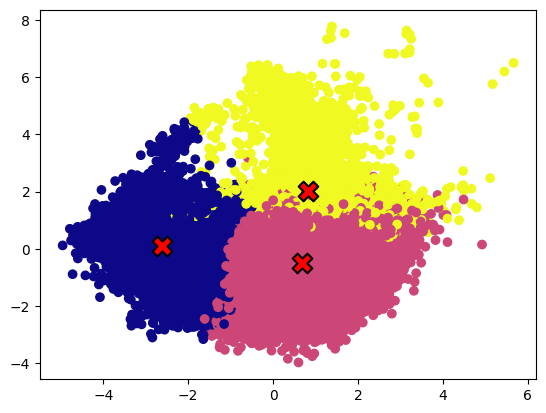

In [124]:
kmeans = KMeans(n_clusters=best_number_of_clusters, random_state=0, n_init='auto')
kmeans.fit(scaled_df)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(transformed_df[:,0],transformed_df[:,1],c=labels,cmap='plasma')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)
plt.show()

In [135]:
cluster_df = pd.DataFrame()
cluster_df['id'] = df.index.values
cluster_df['cluster_num'] = kmeans.labels_
merged_df = cluster_df.merge(games_metadata_df, how='outer', on='id')


In [126]:
merged_df[(merged_df['id'].isin(['o1y9okr6', 'j1llqye1', '369pqq31']))]

,id,cluster_num,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
1854,o1y9okr6,1.0,Hades,yge0m26p,2018-12-06,2018-12-16T18:48:17Z,16,0,6935,1532,0
9491,j1llqye1,1.0,Slay the Spire,v6dvwm62,2017-11-16,2018-01-23T05:09:05Z,5,0,511,155,0
11539,369pqq31,1.0,Hades Category Extensions,yge0m26p,2018-12-06,2020-10-20T16:20:27Z,4,0,134,66,0


In [129]:
merged_df[(merged_df['cluster_num'] == 2)].sort_values(by='num_runs', ascending=False)

,id,cluster_num,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
535,ldep0513,2.0,Final Fantasy XIV: Endwalker,qvegwk60,2013-08-24,2016-09-25T19:14:00Z,13,318,5290,926,1319
558,l3dx51yv,2.0,Super Mario Bros. 3,xv6dvx62,1988-10-23,None,4,0,4393,1016,8
1085,76rxmxq6,2.0,Streets of Rage 4,"4zwny0zk,rzjqd7el",2020-04-30,2020-05-02T06:58:42Z,19,21,3403,280,34
935,m1zjmz60,2.0,Resident Evil 2,myzo3pzq,1998-01-21,None,12,1,3113,671,11
1081,369p0g1l,2.0,The Legend of Zelda,xv6dvx62,1986-02-21,None,8,0,2990,420,3
...,...,...,...,...,...,...,...,...,...,...,...
19943,268e57o6,2.0,Espitene,None,2018-01-01,2018-10-21T02:27:07Z,1,0,1,1,0
12782,76r3k956,2.0,Don't Get Poo'd On By A Reindeer,None,2022-11-22,2022-12-08T03:27:48Z,1,0,1,1,0
12751,m1mnm9pd,2.0,Ultraman Fighting Evolution 2,None,2002-10-31,2021-11-20T15:59:33Z,2,0,1,1,0
12745,9d383701,2.0,Karate Kings Fight 21,None,2019-07-04,2021-09-21T18:11:34Z,1,0,1,1,0


In [136]:
cluster_df = cluster_df.set_index('id')
cluster_df.to_csv("../data/games/network/all_games_structural_equivalence_clusters.csv")

### Link Prediction